# Imports

In [155]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt
from scipy.stats import f
from sklearn.metrics import pairwise_distances
from pandas import ExcelWriter

# Datasets

In [174]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

base_path = Path(parent_dir) / 'Pre-processamento'

file_path_raw = base_path / 'dataset_cotton_fruit.xlsx'
file_path_msc = base_path / 'data_msc.xlsx'
file_path_snv = base_path / 'data_snv.xlsx'
file_path_sg = base_path / 'data_savgol_ordem_1.xlsx'

df_raw = pd.read_excel(file_path_raw)
df_msc = pd.read_excel(file_path_msc)
df_snv = pd.read_excel(file_path_snv)
df_sg = pd.read_excel(file_path_sg)

# Algoritmo

In [175]:
def mean_centering(X):
    return X - np.mean(X, axis=0)


In [176]:
def explained_variance(pca):
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    return cumulative_variance

In [177]:
def jackknife_variance(pca, X):
    loo = LeaveOneOut()
    explained_variances = []

    max_components = min(X.shape[0] - 1, X.shape[1])

    for train_index, _ in loo.split(X):
        X_train = X[train_index]
        
        pca.n_components = min(pca.n_components, max_components)
        pca.fit(X_train)
        
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        explained_variances.append(cumulative_variance)

    mean_explained_variance = np.mean(explained_variances, axis=0)
    std_explained_variance = np.std(explained_variances, axis=0)

    return mean_explained_variance, std_explained_variance


In [178]:
def determine_optimal_components(X_centered, variance_threshold=0.95):
    max_components = min(X_centered.shape)
    pca = PCA(n_components=max_components)
    pca.fit(X_centered)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    optimal_components = np.searchsorted(cumulative_variance, variance_threshold) + 1
    mean_explained_variance, std_explained_variance = jackknife_variance(pca, X_centered)

    min_diff_index = 0
    for i in range(1, len(mean_explained_variance)):
        diff = mean_explained_variance[i] - mean_explained_variance[i - 1]
        if diff <= 0.009:
            min_diff_index = i - 1
            break

    optimal_components = min_diff_index + 1
    print(f"Optimal number of components: {optimal_components}")
    print(f"Variancia explicada: {cumulative_variance[:15]}")
    return optimal_components, mean_explained_variance, std_explained_variance


In [179]:
def validate_optimal_components(X, n_components):
    loo = LeaveOneOut()
    errors = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        reconstruction_error = np.linalg.norm(X_test - pca.inverse_transform(X_test_pca))
        errors.append(reconstruction_error)

    return np.mean(errors)

In [180]:
def detect_outliers(X, pca, alpha=0.05):
    transformed = pca.transform(X)
    T2 = np.sum((transformed ** 2) / pca.explained_variance_, axis=1)
    Q = np.sum((X - pca.inverse_transform(transformed)) ** 2, axis=1)

    n_samples, n_components = X.shape[0], pca.n_components
    T2_limit = n_components * (n_samples - 1) / (n_samples - n_components) * f.ppf(1 - alpha, n_components, n_samples - n_components)

    Q_limit = np.percentile(Q, 100 * (1 - alpha))
    outliers = (T2 > T2_limit) | (Q > Q_limit)
    outlier_indices = np.where(outliers)[0]

    return outliers, T2, Q, T2_limit, Q_limit, outlier_indices

In [181]:
def kennard_stone(data, n_samples):
    distances = pairwise_distances(data)
    first_index = np.argmax(np.linalg.norm(data - np.mean(data, axis=0), axis=1))

    selected_indices = [first_index]

    for _ in range(1, n_samples):
        min_distances = np.min(distances[:, selected_indices], axis=1)
        next_index = np.argmax(min_distances)
        selected_indices.append(next_index)

    return selected_indices

In [182]:
def plot_data(outliers, T2, Q, T2_limit, Q_limit, cumulative_variance, optimal_components):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(cumulative_variance, label='Explained Variance Ratio')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Principal Components')
    plt.axvline(optimal_components - 1, color='r', linestyle='--', label=f'Optimal Components: {optimal_components}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(T2, Q, c=outliers, cmap='coolwarm', edgecolor='k')
    plt.axhline(np.percentile(Q, 100 * (1 - 0.027)), color='r', linestyle='--', label=f'Q Limit: {np.percentile(Q, 100 * (1 - 0.02)):.2f}')
    plt.axvline(T2_limit, color='g', linestyle='--', label=f'T2 Limit: {T2_limit:.2f}')
    plt.xlabel("Hotelling's T²")
    plt.ylabel('F-residual')
    plt.title('Outlier Detection')
    plt.legend(title='Limits')

    plt.tight_layout()
    plt.show()

In [183]:
def save_calibration_validation_data(calibration_data, validation_data, name):
    calibration_file = f"{name}_calibration.xlsx"
    validation_file = f"{name}_validation.xlsx"

    with ExcelWriter(calibration_file, engine='openpyxl') as writer:
        calibration_data.to_excel(writer, index=False)

    with ExcelWriter(validation_file, engine='openpyxl') as writer:
        validation_data.to_excel(writer, index=False)

    print(f"Calibration data saved to '{calibration_file}'")
    print(f"Validation data saved to '{validation_file}'")

In [204]:
def PCA_main(data, name):
    df_data = pd.DataFrame(data)
    df_data_centered = mean_centering(df_data.values)

    optimal_components, _, _ = determine_optimal_components(df_data_centered)
    pca = PCA(n_components=optimal_components) 
    pca.fit(df_data_centered)
    
    val_optimal_components = validate_optimal_components(df_data_centered, optimal_components)
    
    print(f'Cross-Validation Optimal Components: {val_optimal_components}')
    print(f'Optimal Components: {optimal_components}')
    
    cumulative_variance = explained_variance(pca)

    calibration_indices = kennard_stone(df_data_centered, int(0.7 * len(df_data)))
    validation_indices = list(set(range(len(df_data))) - set(calibration_indices))
    
    first_six_columns = pd.concat([df_raw.iloc[:, :5], df_raw.iloc[:, 6]], axis=1)
    
    column_names = list(range(350, 2501))
    df_data_centered_calibration = pd.DataFrame(df_data_centered[calibration_indices, :], columns=column_names)
    df_data_centered_validation = pd.DataFrame(df_data_centered[validation_indices, :], columns=column_names)

    calibration_data = pd.concat([first_six_columns.iloc[calibration_indices].reset_index(drop=True),
                              df_data_centered_calibration], axis=1)

    validation_data = pd.concat([first_six_columns.iloc[validation_indices].reset_index(drop=True),
                             df_data_centered_validation], axis=1)
    
    calibration_data_sorted = calibration_data.sort_values(by=calibration_data.columns[0])
    validation_data_sorted = validation_data.sort_values(by=validation_data.columns[0])

    outliers, T2, Q, T2_limit, Q_limit, outlier_indices = detect_outliers(calibration_data.iloc[:,6:], pca)
    
    plot_data(outliers, T2, Q, T2_limit, Q_limit, cumulative_variance, optimal_components)

    outlier_names = calibration_data_sorted.iloc[outlier_indices, 0]
    outlier_names_list = outlier_names.tolist()

    print(f"Calibration data: {calibration_data.shape}")
    print(f"Validation data: {validation_data.shape}")
    print(f'Outliers detected: {np.sum(outliers)}')

    pd.set_option('display.max_rows', None)
    print(f'Outlier names: {outlier_names_list}')

    print(f"Number of outliers: {sum(outliers)}")
    save_calibration_validation_data(calibration_data_sorted, validation_data_sorted, name)

# Resultados

Optimal number of components: 6
Variancia explicada: [0.63415227 0.81686742 0.9229642  0.9484932  0.96182474 0.9717503
 0.97969092 0.98310792 0.98536647 0.98744093 0.98895468 0.99013494
 0.99124545 0.99219891 0.99290043]
Cross-Validation Optimal Components: 0.07068600701031874
Optimal Components: 6


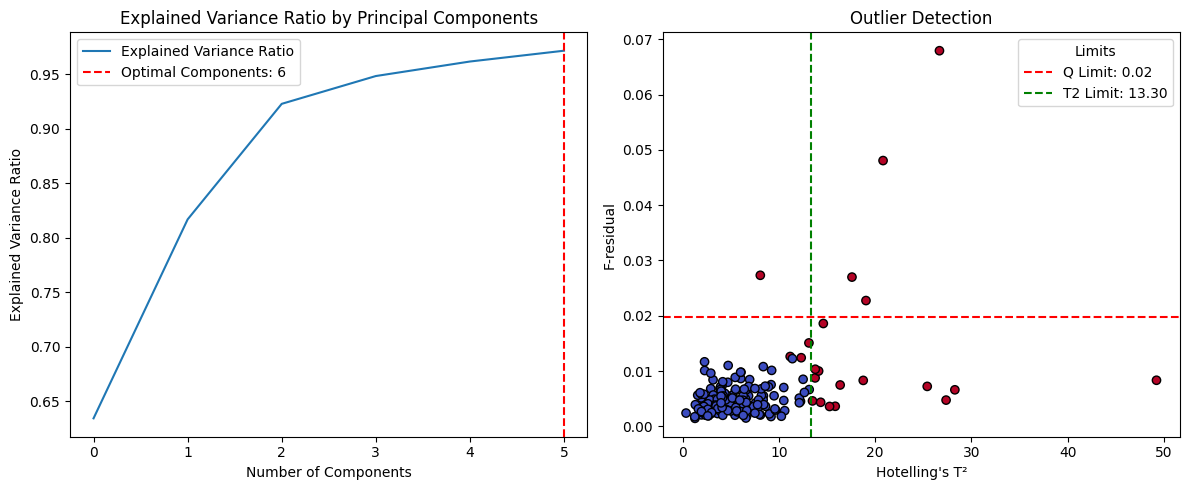

Calibration data: (175, 2157)
Validation data: (75, 2157)
Outliers detected: 22
Outlier names: ['U001', 'U002', 'U006', 'U008', 'U010', 'U013', 'U016', 'U017', 'U025', 'U026', 'U030', 'U031', 'U037', 'U040', 'U041', 'U043', 'U046', 'U068', 'U075', 'U084', 'U119', 'U127']
Number of outliers: 22
Calibration data saved to 'MSC_calibration.xlsx'
Validation data saved to 'MSC_validation.xlsx'
-------------------------------- 



In [205]:
PCA_main(df_msc.values, 'MSC')
print("-------------------------------- \n")

Optimal number of components: 6
Variancia explicada: [0.6276177  0.81172956 0.91893178 0.94480188 0.95827446 0.96834493
 0.97637417 0.98051622 0.98366342 0.98590151 0.98746995 0.98899855
 0.99011957 0.99123601 0.99219725]
Cross-Validation Optimal Components: 0.9528668191444658
Optimal Components: 6


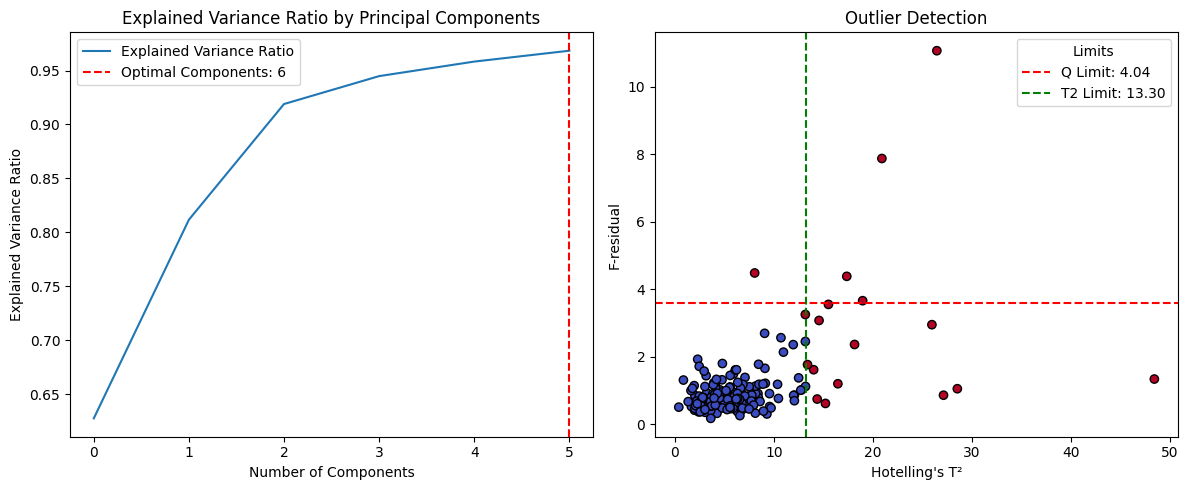

Calibration data: (175, 2157)
Validation data: (75, 2157)
Outliers detected: 18
Outlier names: ['U001', 'U003', 'U009', 'U010', 'U013', 'U018', 'U019', 'U026', 'U027', 'U030', 'U032', 'U040', 'U042', 'U046', 'U074', 'U084', 'U122', 'U137']
Number of outliers: 18
Calibration data saved to 'SNV_calibration.xlsx'
Validation data saved to 'SNV_validation.xlsx'
-------------------------------- 



In [206]:
PCA_main(df_snv.values, 'SNV')
print("-------------------------------- \n")

Optimal number of components: 6
Variancia explicada: [0.54557891 0.84010072 0.92508761 0.95694968 0.96975961 0.98069916
 0.98564854 0.98842194 0.99076455 0.99296083 0.99444907 0.9954255
 0.99616948 0.99684737 0.99735115]
Cross-Validation Optimal Components: 0.0015266562113790364
Optimal Components: 6


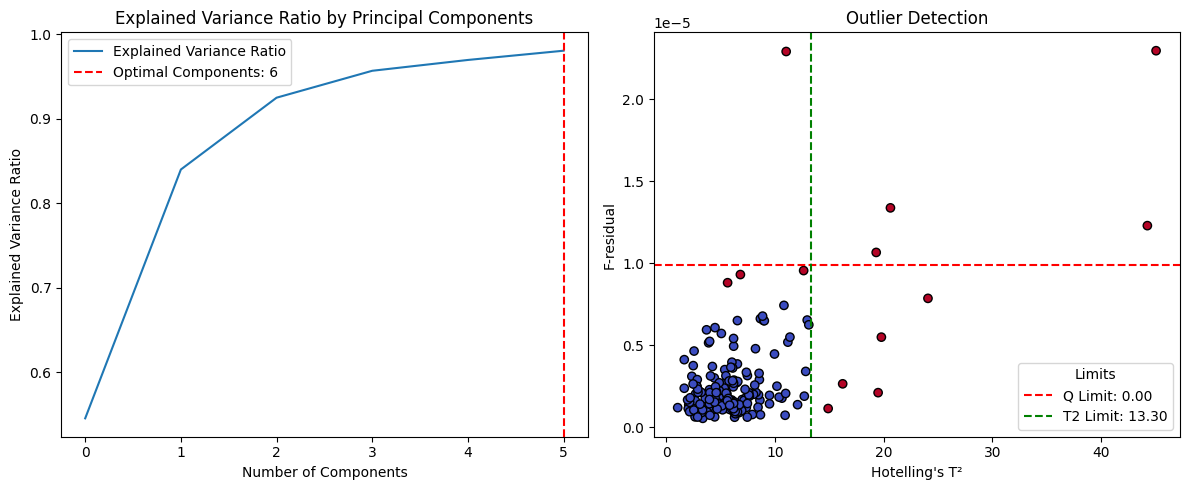

Calibration data: (175, 2157)
Validation data: (75, 2157)
Outliers detected: 13
Outlier names: ['U002', 'U010', 'U011', 'U016', 'U022', 'U025', 'U026', 'U029', 'U051', 'U054', 'U074', 'U078', 'U179']
Number of outliers: 13
Calibration data saved to 'SG_calibration.xlsx'
Validation data saved to 'SG_validation.xlsx'
-------------------------------- 



In [207]:
PCA_main(df_sg.values, 'SG')
print("-------------------------------- \n")

Optimal number of components: 5
Variancia explicada: [0.79357848 0.89408923 0.94695618 0.97165512 0.98795581 0.99200699
 0.9941838  0.9958335  0.99700176 0.99750377 0.99785345 0.99816128
 0.99839373 0.99858083 0.9987218 ]
Cross-Validation Optimal Components: 0.11099792619750923
Optimal Components: 5


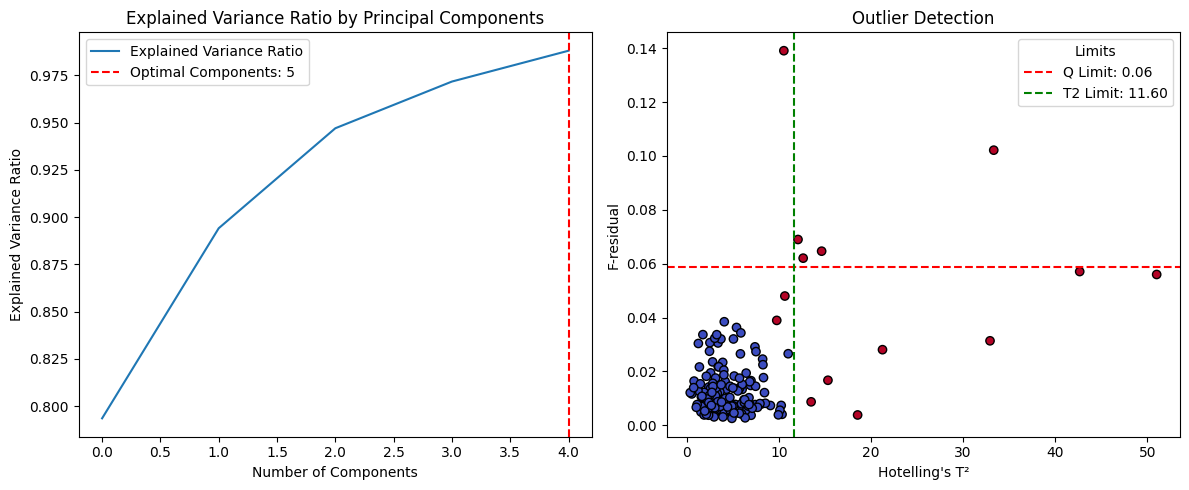

Calibration data: (175, 2157)
Validation data: (75, 2157)
Outliers detected: 14
Outlier names: ['U001', 'U003', 'U004', 'U013', 'U016', 'U026', 'U028', 'U031', 'U041', 'U056', 'U058', 'U075', 'U128', 'U174']
Number of outliers: 14
Calibration data saved to 'RAW_calibration.xlsx'
Validation data saved to 'RAW_validation.xlsx'
-------------------------------- 



In [208]:
PCA_main(df_raw.iloc[:, 7:].values, 'RAW')
print("-------------------------------- \n")